In [1]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats
#double iteration in pandas
from itertools import product
#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
from windrose import WindroseAxes

%matplotlib inline

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in

# SARAL-AltiKa 

In [12]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    '''
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    '''

    return outliers_removed

In [10]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/SA_val')

# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh = pd.concat(results)

In [11]:
swh_sa = swh[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa 

,time,lon,lat,swh,wind_speed_alt
0,2016-07-07 10:14:49.624763008,289.648891,40.191881,1.013,1.13
1,2016-07-07 10:14:52.742073088,289.588603,40.374652,1.090,1.35
2,2016-07-07 10:14:53.781178944,289.568450,40.435571,0.786,1.17
3,2016-07-07 10:14:54.820281984,289.548268,40.496486,0.979,1.23
4,2016-07-07 10:14:55.859388096,289.528058,40.557399,1.097,1.50
...,...,...,...,...,...
5829,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
5830,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
5831,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
5832,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


In [5]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")

In [13]:
# coordinates of buoy 44097
b44097 = (buoys['Latitude'][0],buoys['Longitude'][0]+360)
b44097

(40.969, 288.873)

In [14]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [15]:
#read all files since 2016 for the 44097 buoy and concatenate them into one single pandas data frame and exclude wave height error values
path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44097_1'
all_files = glob.glob(path + "/*.txt")

b44097_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,8,9], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44097_wave = b44097_wave[b44097_wave.WVHT !=99]
b44097_wave.reset_index(inplace=True)
b44097_wave.drop('index', 1, inplace=True)
b44097_wave

,Date,WVHT,DPD
0,2016-05-13 18:55:00,0.65,8.33
1,2016-05-13 19:25:00,0.62,9.09
2,2016-05-13 19:55:00,0.61,8.33
3,2016-05-13 20:55:00,0.58,9.09
4,2016-05-13 21:25:00,0.60,13.33
...,...,...,...
56422,2019-12-31 21:30:00,2.03,9.09
56423,2019-12-31 22:00:00,1.75,9.88
56424,2019-12-31 22:30:00,1.83,9.09
56425,2019-12-31 23:00:00,1.99,9.09


In [16]:
b44097_time = b44097_wave['Date']
b44097_time

0       2016-05-13 18:55:00
1       2016-05-13 19:25:00
2       2016-05-13 19:55:00
3       2016-05-13 20:55:00
4       2016-05-13 21:25:00
                ...        
56422   2019-12-31 21:30:00
56423   2019-12-31 22:00:00
56424   2019-12-31 22:30:00
56425   2019-12-31 23:00:00
56426   2019-12-31 23:30:00
Name: Date, Length: 56427, dtype: datetime64[ns]

In [17]:
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]

In [18]:
# compute the distance between each SARAL-AltiKa and the position of buoy 44097
hav5 = haversine_vector([b44097]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,108.445160
1,89.497867
2,83.396777
3,77.445776
4,71.682124
...,...
5829,253.366240
5830,252.096991
5831,251.014717
5832,250.121589


In [19]:
swh_sa['Buoy-Sat. Distance (km)'] = coloc
swh_sa

,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
0,2016-07-07 10:14:49.624763008,289.648891,40.191881,1.013,1.13,108.445160
1,2016-07-07 10:14:52.742073088,289.588603,40.374652,1.090,1.35,89.497867
2,2016-07-07 10:14:53.781178944,289.568450,40.435571,0.786,1.17,83.396777
3,2016-07-07 10:14:54.820281984,289.548268,40.496486,0.979,1.23,77.445776
4,2016-07-07 10:14:55.859388096,289.528058,40.557399,1.097,1.50,71.682124
...,...,...,...,...,...,...
5829,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69,253.366240
5830,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74,252.096991
5831,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58,251.014717
5832,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26,250.121589


In [20]:
# keep satellite observations in a radius of 10 km relative to the buoy
#dist = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
radius = swh_sa['Buoy-Sat. Distance (km)'] < 15.
colocated = swh_sa[radius]
colocated.reset_index(inplace=True)
colocated.drop('index', 1, inplace=True)
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
0,2016-07-23 10:16:34.646852992,289.002711,40.907642,1.686,6.56,12.855418
1,2016-07-23 10:16:35.685429120,288.982312,40.968513,1.613,6.91,9.177968
2,2016-07-23 10:16:36.724005952,288.961884,41.029382,1.785,6.91,10.035956
3,2016-07-23 10:16:37.762582080,288.941426,41.090247,1.538,6.22,14.653008
4,2016-09-14 23:17:01.762003904,288.721457,41.000106,1.100,5.72,13.182328
...,...,...,...,...,...,...
106,2019-08-05 23:10:28.532795008,289.021439,40.960348,0.878,3.91,12.500747
107,2019-08-05 23:10:29.570313984,289.001063,40.899524,0.812,4.10,13.244279
108,2019-08-21 23:11:26.007042944,288.784263,41.035330,1.310,7.84,10.480950
109,2019-08-21 23:11:27.045093120,288.763841,40.974486,1.163,7.66,9.184828


In [21]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)

In [22]:
#time difference in minutes
diff = [(b44097_time[d], b44097_wave['WVHT'][d], sat_time['time'][s], colocated['swh'][s], \
         colocated['Buoy-Sat. Distance (km)'][s], (sat_time['time'][s] - b44097_time[d]).total_seconds() / 60) \
        for d, s in product(range(b44097_time.shape[0]), range(sat_time.shape[0]))]

In [23]:
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44097 Time', 'Buoy 44097 Wave Height', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', \
             'Buoy-Sat. Distance (km)', 'Time Difference (min.)']
t

,Buoy 44097 Time,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,Buoy-Sat. Distance (km),Time Difference (min.)
0,2016-05-13 18:55:00,0.65,2016-07-23 10:16:34.646852992,1.686,12.855418,101721.577448
1,2016-05-13 18:55:00,0.65,2016-07-23 10:16:35.685429120,1.613,9.177968,101721.594757
2,2016-05-13 18:55:00,0.65,2016-07-23 10:16:36.724005952,1.785,10.035956,101721.612067
3,2016-05-13 18:55:00,0.65,2016-07-23 10:16:37.762582080,1.538,14.653008,101721.629376
4,2016-05-13 18:55:00,0.65,2016-09-14 23:17:01.762003904,1.100,13.182328,178822.029367
...,...,...,...,...,...,...
6263392,2019-12-31 23:30:00,1.93,2019-08-05 23:10:28.532795008,0.878,12.500747,-213139.524453
6263393,2019-12-31 23:30:00,1.93,2019-08-05 23:10:29.570313984,0.812,13.244279,-213139.507161
6263394,2019-12-31 23:30:00,1.93,2019-08-21 23:11:26.007042944,1.310,10.480950,-190098.566549
6263395,2019-12-31 23:30:00,1.93,2019-08-21 23:11:27.045093120,1.163,9.184828,-190098.549248


In [25]:
final = abs(t['Time Difference (min.)']) < 15.
final1 = t[final]
final1 = final1.set_index('Buoy 44097 Time')
final1

,Buoy 44097 Wave Height,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,Buoy-Sat. Distance (km),Time Difference (min.)
Buoy 44097 Time,,,,,
2016-07-23 10:25:00,1.52,2016-07-23 10:16:34.646852992,1.686,12.855418,-8.422552
2016-07-23 10:25:00,1.52,2016-07-23 10:16:35.685429120,1.613,9.177968,-8.405243
2016-07-23 10:25:00,1.52,2016-07-23 10:16:36.724005952,1.785,10.035956,-8.387933
2016-07-23 10:25:00,1.52,2016-07-23 10:16:37.762582080,1.538,14.653008,-8.370624
2016-09-14 23:25:00,1.16,2016-09-14 23:17:01.762003904,1.100,13.182328,-7.970633
...,...,...,...,...,...
2019-08-05 23:00:00,0.72,2019-08-05 23:10:28.532795008,0.878,12.500747,10.475547
2019-08-05 23:00:00,0.72,2019-08-05 23:10:29.570313984,0.812,13.244279,10.492839
2019-08-21 23:00:00,1.24,2019-08-21 23:11:26.007042944,1.310,10.480950,11.433451


In [29]:
df1 = final1.iloc[:,[0,2]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df1 = df1.resample('D').mean()
df1 = df1.dropna()
df1

,Buoy 44097 Wave Height,SARAL-AltiKa Wave Height
Buoy 44097 Time,,
2016-07-23,1.52,1.655500
2016-09-14,1.16,1.104500
2016-11-14,1.34,1.350800
2016-12-08,1.21,1.171200
2017-01-30,0.95,1.029000
2017-02-23,0.92,0.866400
2017-04-17,1.39,1.469000
2017-05-11,0.75,0.779250
2017-07-03,0.84,0.822500


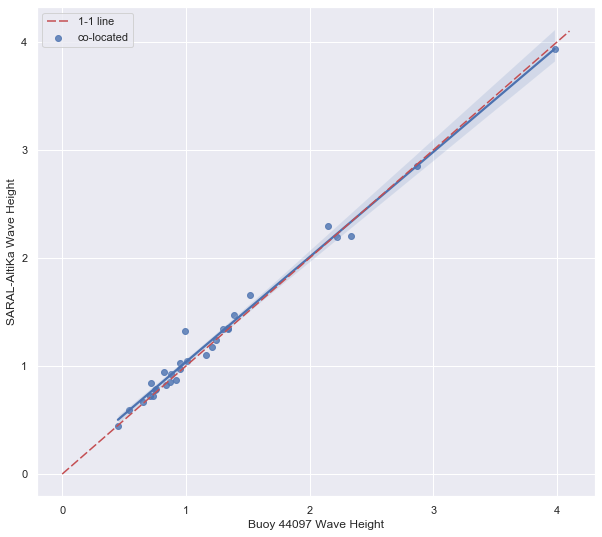

In [57]:
f, ax = plt.subplots(figsize=(10, 9))
ax = sns.regplot(x='Buoy 44097 Wave Height', y='SARAL-AltiKa Wave Height', data=df1, label='co-located')
line2 = plt.plot([0, 4.1], [0, 4.1], dashes=[6, 2], color='r', label='1-1 line')
ax.legend()

In [31]:
#correlation coefficient and p-value (statistical significance)
scipy.stats.pearsonr(df1['Buoy 44097 Wave Height'], df1['SARAL-AltiKa Wave Height'])

(0.9940750377872967, 1.5519270201316795e-28)

In [32]:
scipy.stats.spearmanr(df1['Buoy 44097 Wave Height'], df1['SARAL-AltiKa Wave Height'])

SpearmanrResult(correlation=0.9838655897116131, pvalue=1.7979837681751026e-22)

In [59]:
# root mean squared error
sqrt(mean_squared_error(df1['Buoy 44097 Wave Height'], df1['SARAL-AltiKa Wave Height']))

0.08798891479537099